In [1]:
import pandas as pd
import numpy as np

straight
difference

window
bidirectional

one-hot
kidera / atchley

clusterize => assign weights accroding to the clusters' sizes

In [2]:
coord = "x"
df_cdr = pd.read_csv("data/cdr_coord_" + coord + ".csv.gz")
df_put = pd.read_csv("data/put_coord_" + coord + ".csv.gz")
df_can = pd.read_csv("data/can_coord_" + coord + ".csv.gz")

print(df_cdr.shape)
print(df_put.shape)
print(df_can.shape)

df_can.head()

(69, 16)
(74528, 16)
(281, 16)


,Unnamed: 0,key,sequence,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0,1a3r_H_94,CDGYYSYYDMDYW,0.0,2.328698,3.429601,5.486569,7.316678,8.250524,10.507312,13.006086,12.028587,11.479460,8.852804,7.908799,5.945195
1,1,1adq_L_85,CQVWDSSSDHAVF,0.0,2.614351,3.393366,5.985476,7.876394,8.216074,10.739815,13.479405,12.450132,11.866968,8.916183,7.957197,5.782122
2,2,1bwm_A_88,CASGGQGRAEQFF,0.0,2.589446,3.084727,5.569359,5.842311,5.635476,8.512440,10.888701,10.627411,10.732431,7.404510,7.793864,6.071859
3,3,1epf_A_169,CEGRILARGEINF,0.0,2.451093,3.625820,5.505635,6.952395,7.135661,9.123333,11.949183,11.398156,11.040971,8.929229,8.209337,5.596295
4,4,1epf_B_171,CEGRILARGEINF,0.0,2.387851,3.648702,5.559502,6.893447,6.200318,9.028199,11.535051,11.500070,11.033876,8.922183,8.186983,5.536115


In [87]:
MAX_POS=12

chars = ["A", "L", "R", 'K', 'N', 'M', 'D', 'F', 'C', 'P', 'Q', 'S', 'E', 'T', 'G', 'W', 'H', 'Y', 'I', 'V']
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
one_hot = dict((c, np.zeros((len(chars),), dtype=bool)) for c in chars)
for c in one_hot:
    one_hot[c][char_indices[c]] = 1

def to_vec_onehot(df, left_window, right_window):
    X = np.zeros((len(df)*MAX_POS, (left_window+right_window+1) * len(chars)), dtype=bool)
    y = np.zeros((len(df)*MAX_POS, 1), dtype=np.float32)
    for seq_i, seq in enumerate(df["sequence"]):
        seq = "X"*left_window + seq + "X"*right_window
        for index, target_pos in enumerate(range(left_window + 1, len(seq) - right_window)):
            target_aa = seq[target_pos]
            for amb_pos, amb_aa in enumerate(seq[target_pos-left_window : target_pos+right_window+1]):
                if amb_aa != "X":
                    X[seq_i*MAX_POS + index, amb_pos*len(chars):(amb_pos+1)*len(chars)] = one_hot[amb_aa]
            y[seq_i*MAX_POS + index] = df[[4 + index]].iloc[seq_i]
    return X, y


def to_vec_kidera(df, left_window, right_window):
    X = np.zeros((len(df)*MAX_POS, (left_window+right_window+1) * len(chars)), dtype=bool)
    y = np.zeros((len(df)*MAX_POS, 1), dtype=np.float32)
    for seq_i, seq in enumerate(df["sequence"]):
        seq = "X"*left_window + seq + "X"*right_window
        for index, target_pos in enumerate(range(left_window + 1, len(seq) - right_window)):
            target_aa = seq[target_pos]
            for amb_pos, amb_aa in enumerate(seq[target_pos-left_window : target_pos+right_window+1]):
                if amb_aa != "X":
                    X[seq_i*MAX_POS + index, amb_pos*len(chars):(amb_pos+1)*len(chars)] = one_hot[amb_aa]
            y[seq_i*MAX_POS + index] = df[[4 + index]].iloc[seq_i]
    return X, y

X_can, y_can = to_vec(df_can, 3, 3)
print(X_can.shape)
#X_put, y_put = to_vec(df_put, 1, 1)
#print(X_put.shape)
X_cdr, y_cdr = to_vec(df_cdr, 3, 3)
print(X_cdr.shape)

(3372, 140)
(828, 140)


In [100]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers.advanced_activations import PReLU

model_name = "dense2_win3"
model = Sequential()
model.add(Dense(64, input_shape=(140,)))
model.add(BatchNormalization())
model.add(Dropout(.3))
model.add(PReLU())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Dropout(.3))
model.add(PReLU())

model.add(Dense(1))
model.add(PReLU())
model.compile(optimizer="nadam", loss="mse")

In [101]:
def train(model):
    return model.fit(X_can, y_can, batch_size=128, epochs=2000, verbose=0, validation_data=(X_cdr, y_cdr))

# hist = {}
hist[model_name] = train(model)

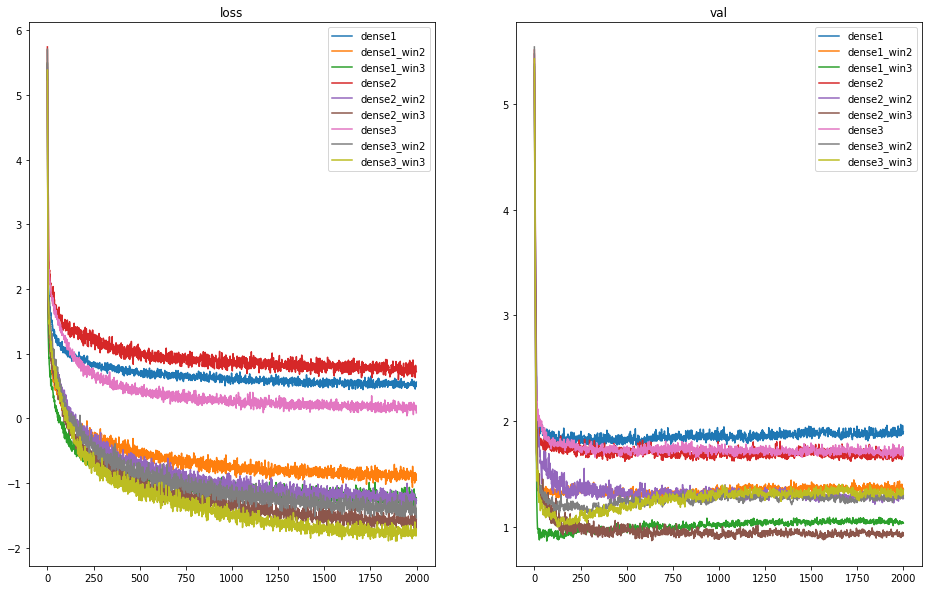

In [102]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, sharex=True, ncols=2)
fig.set_figwidth(16)
fig.set_figheight(10)

for i, h in enumerate(sorted(hist)):
    ax[0].plot(np.log2(hist[h].history["loss"]), label=h)
    ax[1].plot(np.log2(hist[h].history["val_loss"]), label=h)


ax[0].set_title("loss")
ax[1].set_title("val")
ax[0].legend()
ax[1].legend()

plt.savefig("loss_dense_onehot_nn.png")

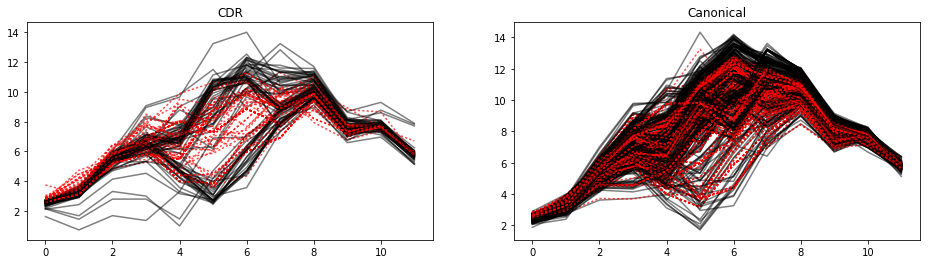

In [103]:
# Predicted and real coordinates
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(16)

pred = model.predict(X_cdr)
trans = pred.reshape((len(df_cdr),12))
for i in range(len(df_cdr)):
    ax[0].plot(range(12), df_cdr.iloc[i,4:16], c="black", alpha=.5, label="real")
    ax[0].plot(trans[i,:], c = "red", linestyle="dotted", alpha=.7, label="pred")
ax[0].set_title("CDR")
    
pred = model.predict(X_can)
trans = pred.reshape((len(df_can),12))
for i in range(len(df_can)):
    ax[1].plot(range(12), df_can.iloc[i,4:16], c="black", alpha=.5, label="real")
    ax[1].plot(trans[i,:], c = "red", linestyle="dotted", alpha=.7, label="pred")
ax[1].set_title("Canonical")

plt.savefig("pred_dense_onehot_nn.png")